***Creating a synthetic dataset***

First, we create a dataset for the 'unknown' oscillator parameters. Start by defining our problem setup, core functions, etc.

Then, calculate $\ddot{q}$ for each point in the $(q,\dot{q})$ set and plot the results:

Time elapsed = 1.4e-02 sec for n_points = 100, n_points total = 1.0e+04


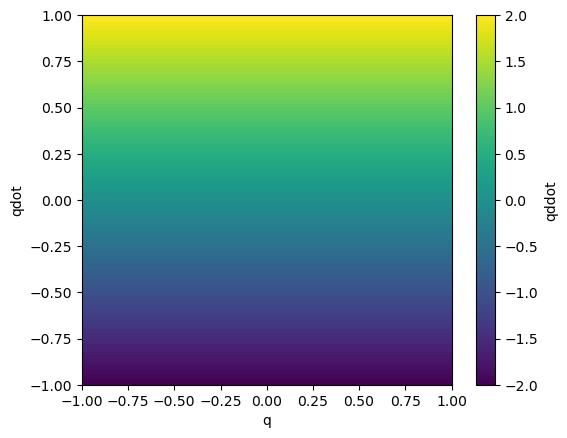

In [4]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tqdm
from torch.func import jacfwd, vmap
import time
from torch import tensor

torch.manual_seed(0)

m = torch.tensor([2],dtype=torch.float64)
k = torch.tensor([4],dtype=torch.float64)
alpha = torch.tensor([.0],dtype=torch.float64) #ignore this parameter for now

n_points = 100
q_min = -1
q_max = 1
qdot_min = -1
qdot_max = 1

def L(q,qdot,m,k,alpha):
    return 0.5*m*qdot**2 - 0.5*k*q**2 - alpha*q**2*qdot**2

qgrid = torch.linspace(q_min,q_max,n_points) #(n_points)
qdotgrid = torch.linspace(qdot_min,qdot_max,n_points) #(n_points)

#define flattened q, qdot arrays (n_points^2), (n_points^2), using new torch.expand.reshape method.
Q = qgrid.expand([n_points,n_points]).reshape(n_points**2)
QD = qdotgrid.expand([n_points,n_points]).reshape(n_points**2)

im = 0*torch.zeros([n_points,n_points])
#print(im.shape)

def QDD(Q,QD,m,k,alpha):
    g_q2 = jacfwd(L,argnums=0)(Q,QD,m,k,alpha)
    g_qdot2 = jacfwd(L,argnums=1)(Q,QD,m,k,alpha)
    
    g_q_qdot2 = jacfwd(jacfwd(L,argnums=1),argnums=0)(Q,QD,m,k,alpha)
    g_qdot_q2 = jacfwd(jacfwd(L,argnums=0),argnums=1)(Q,QD,m,k,alpha)
    g_qdot_qdot2 = jacfwd(jacfwd(L,argnums=1),argnums=1)(Q,QD,m,k,alpha)
    D = g_qdot_qdot2**(-1)
    return D*(g_q2 - g_q_qdot2*QD)

tic_v2 = time.time()


QDDv = vmap(QDD,in_dims=(0,0,None,None,None))

out = QDDv(Q,QD,m,k,alpha)
im = out.reshape([n_points,n_points]).T

t_elapsed_v2 = time.time()-tic_v2
print(f"Time elapsed = {t_elapsed_v2:.1e} sec for n_points = {n_points}, n_points total = {n_points**2:.1e}")

#print(im.shape)

plt.imshow(im,extent=[q_min,q_max,qdot_min,qdot_max])
plt.xlabel('q')
plt.ylabel('qdot')
plt.colorbar(label='qddot')
plt.show()

***Loss visualization***
Now, disregard the originally defined oscillator parameters, and plot the loss function value at each $(m_{trial},k_{trial})$ point.

100%|██████████| 150/150 [01:30<00:00,  1.66it/s]

The original parameters are m = 2.0, k = 4.0


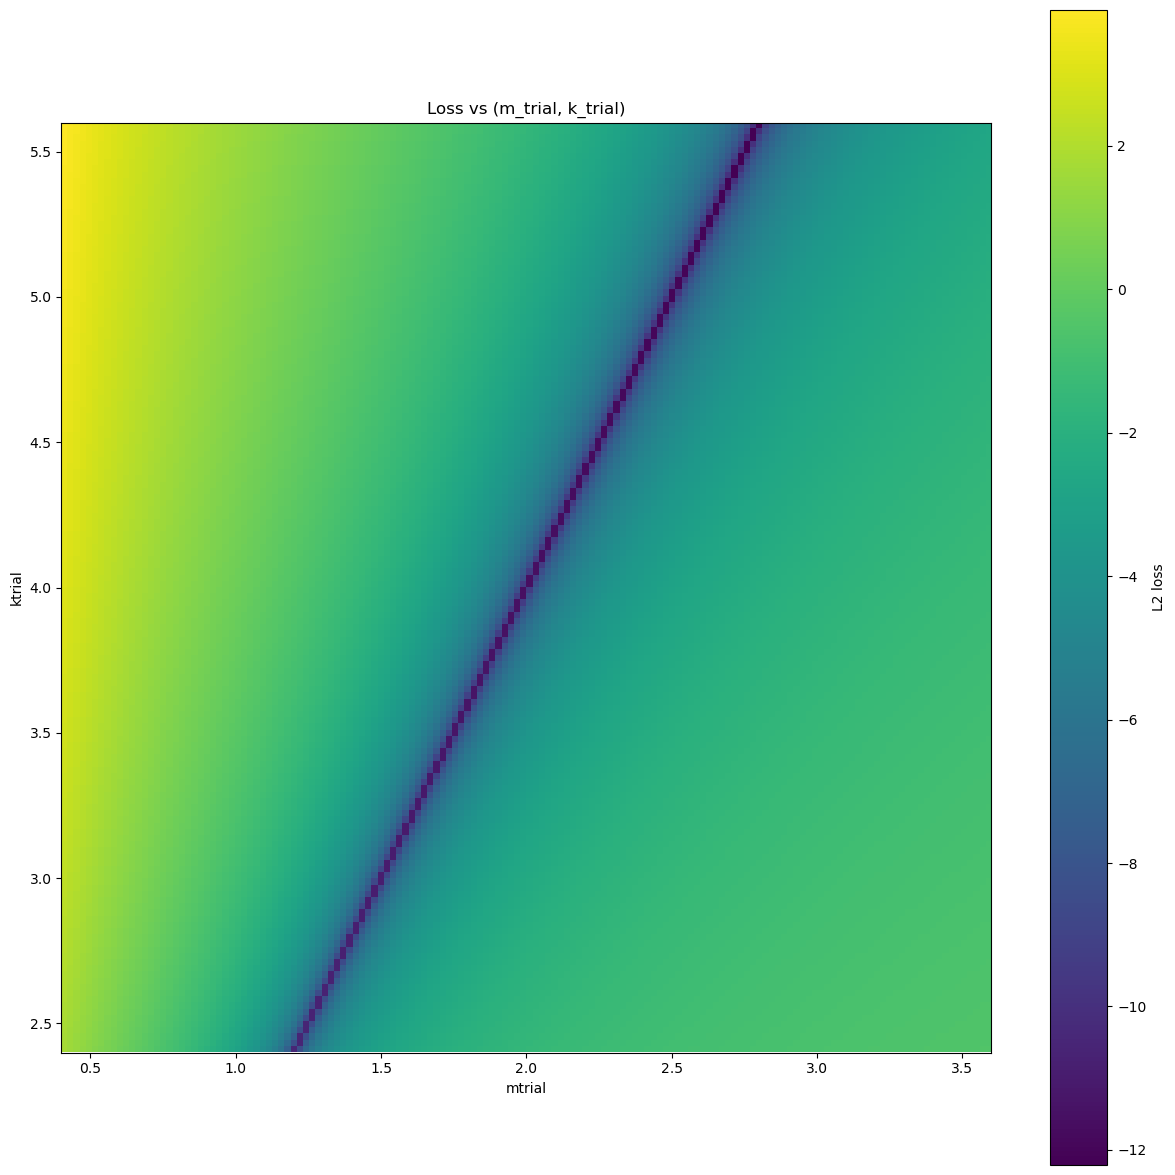

In [10]:
n_param_points = 150
box_width = 1.6

m_min = m[0] - box_width
m_max = m[0] + box_width
k_min = k[0] - box_width
k_max = k[0] + box_width
"""
m_min = 0.6
m_max = 1.4
k_min = 1.6
k_max = 2.4
"""
mtrialgrid = torch.linspace(m_min,m_max,n_param_points)
ktrialgrid = torch.linspace(k_min,k_max,n_param_points)


def L(q,qdot,m,k,alpha):
    return 0.5*m*qdot**2 - 0.5*k*q**2 - alpha*q**2*qdot**2

def loss(q,qdot,m,k,alpha,dataset):
    return torch.sum((QDDv(q,qdot,m,k,alpha) - dataset)**2)/dataset.size()[0]

qgrid = torch.linspace(q_min,q_max,n_points) #(n_points)
qdotgrid = torch.linspace(qdot_min,qdot_max,n_points) #(n_points)

#define flattened q, qdot arrays (n_points^2), (n_points^2), using new torch.expand.reshape method.
Q = qgrid.expand([n_points,n_points]).reshape(n_points**2)
QD = qdotgrid.expand([n_points,n_points]).reshape(n_points**2)

loss_mat = torch.zeros([n_param_points, n_param_points])


sz = out.size(1)
qdd_trials = torch.zeros(sz)

for i in tqdm.trange(n_param_points): #iterate over m
    mtrial = tensor([mtrialgrid[i]], requires_grad = True) #pick m_trial value from grid
    for j in range(n_param_points): #iterate over k
        ktrial = tensor([ktrialgrid[j]], requires_grad = True) #pick k_trial value from grid

        #qdd_trials = QDDv(Q,QD,mtrial,ktrial,alpha)
        
        #loss_mat[i,j] = torch.sum( (qdd_trials - out)**2 )/sz #calculate loss function
        loss_mat[i,j] = loss(Q,QD,mtrial,ktrial,alpha,out)




print(f"The original parameters are m = {m[0]}, k = {k[0]}")

#plotting
fig, axs = plt.subplots(1,1,figsize=(15,15))
test = axs.imshow(np.log(loss_mat.detach().numpy().T+1e-12), extent=[m_min,m_max,k_min,k_max],origin='lower')

axs.set_xlabel('mtrial')
axs.set_ylabel('ktrial')
fig.colorbar(test, ax=axs,label='L2 loss')
axs.set_title("Loss vs (m_trial, k_trial)")

plt.show()



***Gradient descent***

Here we fit the optimal oscillator parameters given a random guess for $(m_{trial},k_{trial})$ and see that it converges quickly to the originally defined $k/m$ ratio.

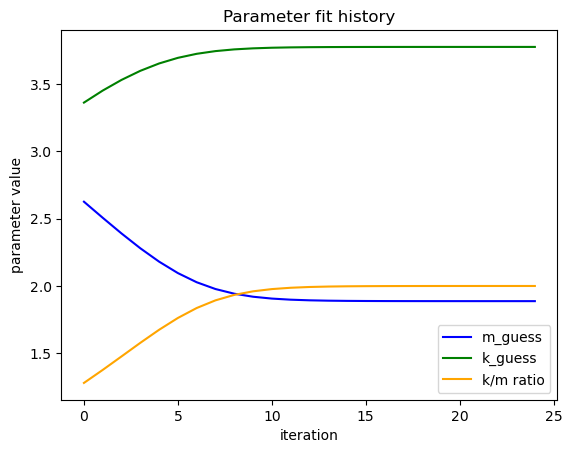

In [44]:
#####
# define gradient w.r.t. parameters
dlossdm = jacfwd(loss,argnums=2)
dlossdk = jacfwd(loss,argnums=3)

trial_iters = 25
learning_rate = 5e-1

guess_m = 2*box_width*(torch.rand(1)-0.5)+m[0]
guess_k = 2*box_width*(torch.rand(1)-0.5)+k[0]

guess_m_array = torch.zeros(trial_iters)
guess_k_array = torch.zeros(trial_iters)
iter_array = torch.arange(0,trial_iters,1)

for i in range(trial_iters):
    guess_m.data += -learning_rate*dlossdm(Q,QD,guess_m,guess_k,alpha,out)
    guess_k.data += -learning_rate*dlossdk(Q,QD,guess_m,guess_k,alpha,out)

    guess_m_array[i] = torch.clone(guess_m)
    guess_k_array[i] = torch.clone(guess_k)
    
plt.plot(iter_array,guess_m_array,color='blue',label='m_guess')
plt.plot(iter_array,guess_k_array,color='green',label='k_guess')
plt.plot(iter_array,guess_k_array/guess_m_array,color='orange',label='k/m ratio')
plt.xlabel('iteration')
plt.ylabel('parameter value')
plt.title('Parameter fit history')
plt.legend()
plt.show()

In the following cell, we do the same as before (fitting via gradient descent), but plotting the parameter paths against the loss landscape.

The color of the scatter dots indicates the iteration at that step.

Note: To cope with the extremely large range of loss values, there is an effective $\epsilon = \epsilon_0 e^{(\epsilon_0 * |\nabla l|)^p}$ learning rate slowdown.

100%|██████████| 25/25 [00:48<00:00,  1.93s/it]


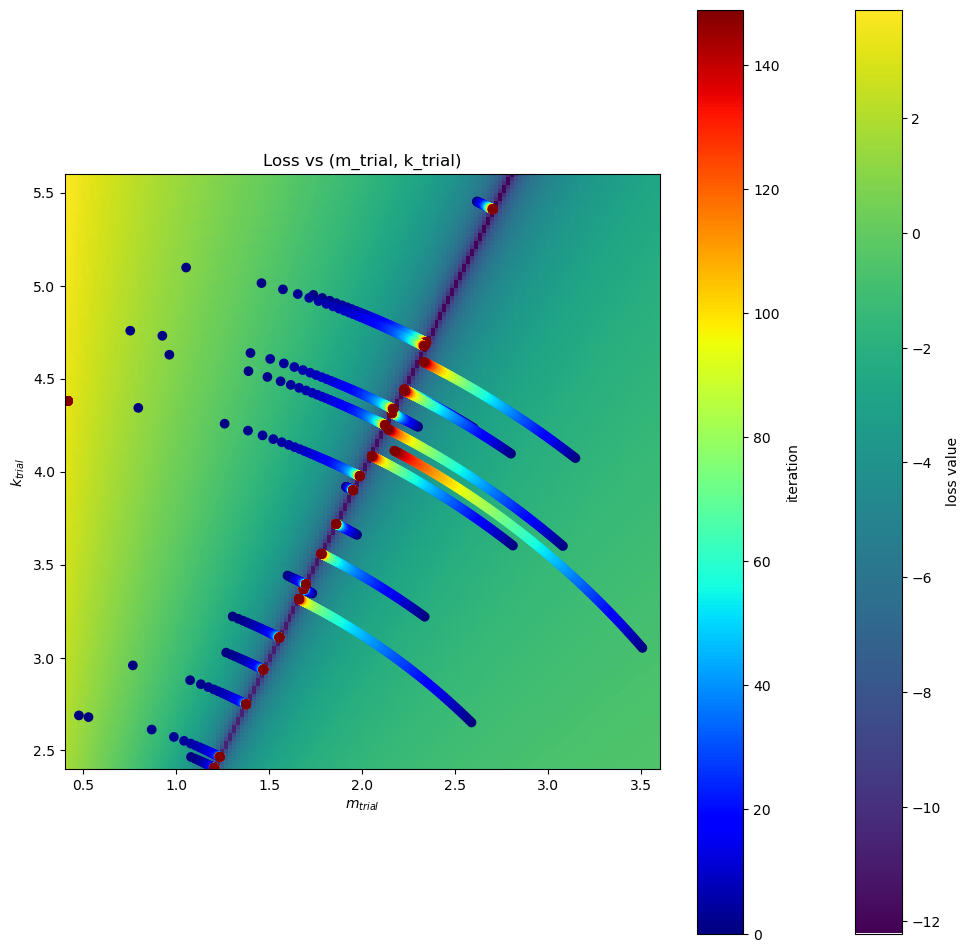

In [48]:
#####
# define gradient w.r.t. parameters
dlossdm = jacfwd(loss,argnums=2)
dlossdk = jacfwd(loss,argnums=3)


fig, axs = plt.subplots(1,1,figsize=(12,12))
test = axs.imshow(np.log(loss_mat.detach().numpy().T+1e-12), extent=[m_min,m_max,k_min,k_max],origin='lower')
axs.set_xlabel(r'$m_{trial}$')
axs.set_ylabel(r'$k_{trial}$')
fig.colorbar(test, ax=axs,label='loss value')
axs.set_title("Loss vs (m_trial, k_trial)")

n_trials = 25
trial_iters = 150
learning_rate = 5e-2

guess_m_array = torch.zeros(trial_iters)
guess_k_array = torch.zeros(trial_iters)
iter_array = torch.arange(0,trial_iters,1)

guess_m = tensor([0])
guess_k = tensor([0])

guesses_m = box_width*2*(torch.rand(n_trials)-0.5)+m
guesses_k = box_width*2*(torch.rand(n_trials)-0.5)+k

for j in tqdm.trange(n_trials):
    guess_m = torch.clone(guesses_m[j])
    guess_k = torch.clone(guesses_k[j])
    for i in range(trial_iters):
        guess_m_array[i] = torch.clone(guess_m)
        guess_k_array[i] = torch.clone(guess_k)
        
        dldm = dlossdm(Q,QD,guess_m,guess_k,alpha,out)
        dldk = dlossdk(Q,QD,guess_m,guess_k,alpha,out)
        d_tot = (dldm**2 + dldk**2)**.5
        d_scale = torch.exp(-(learning_rate*d_tot)**3)**1
        
        guess_m.data += -learning_rate*dldm*d_scale
        guess_k.data += -learning_rate*dldk*d_scale
    
        
    points = axs.scatter(guess_m_array,guess_k_array,c=iter_array,cmap='jet')

plt.colorbar(points,ax=axs, label='iteration')
axs.set_xlim(left= (m[0] - box_width), right = m[0] + box_width)
axs.set_ylim(bottom=k[0] - box_width, top = k[0] + box_width)

plt.show()


100%|██████████| 20/20 [01:03<00:00,  3.16s/it]


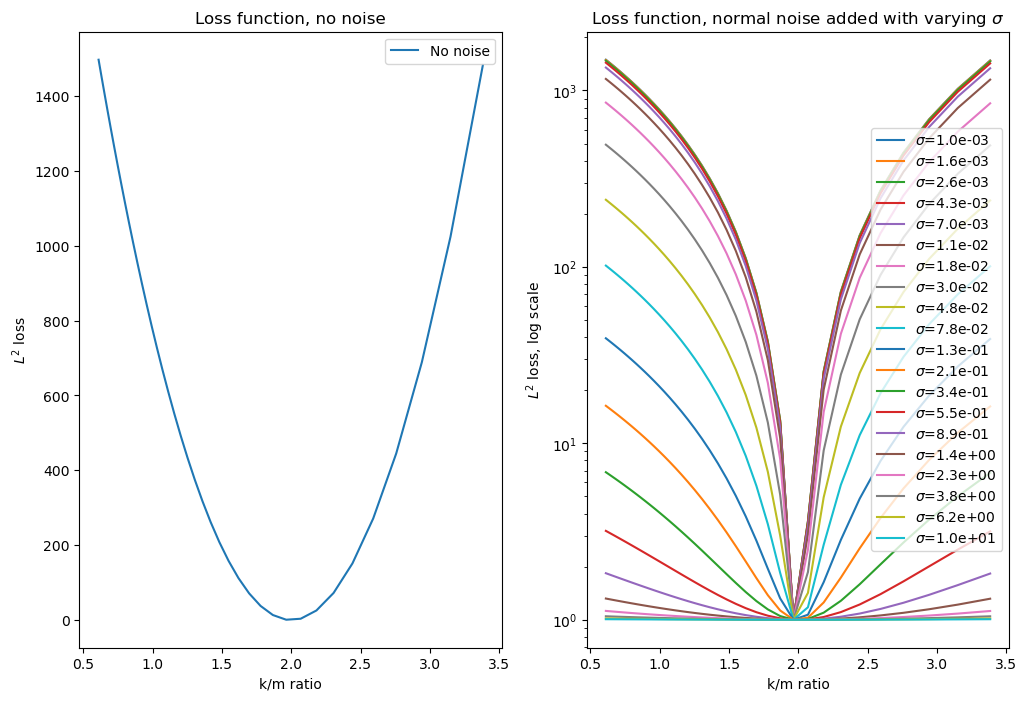

In [235]:
#Visualize slice of loss function

n_trials = 40


guess_m_array = torch.linspace(m[0]-box_width/1.65,m[0]+box_width/1,n_trials)
guess_k_array = guess_m_array*(-m/k) + 1.*k
iter_array = torch.arange(0,trial_iters,1)

guess_m = tensor([0])
guess_k = tensor([0])

loss_slice = torch.zeros(n_trials)
loss_slice_noisy = torch.zeros(n_trials)

n_powers = 20
sigma_powers = torch.linspace(-3,1,n_powers)
sigma_array = 10**sigma_powers
noise_sigma=0.1

n_sigmas = sigma_array.size()[0]
rms_errors = torch.zeros(sigma_array.size()[0])



for j in tqdm.trange(n_trials):
    guess_m = torch.clone(guess_m_array[j])
    guess_k = torch.clone(guess_k_array[j])
    loss_slice[j] = loss(Q,QD,guess_m,guess_k,alpha,out)
    
#plt.scatter(guess_m_array,guess_k_array)
#plt.show()

fig, axs = plt.subplots(1,2,figsize=(12,8))
axs[0].plot(guess_k_array/guess_m_array,loss_slice/torch.min(loss_slice),label='No noise')
#axs[0].plot(guess_k_array/guess_m_array,loss_slice_noisy/torch.min(loss_slice_noisy),label='noise added')
axs[0].set_xlabel('k/m ratio')
axs[0].set_ylabel(r'$L^2$ loss')
axs[0].set_title('Loss function, no noise')
axs[0].legend()


for l in tqdm.trange(n_sigmas):
    noise_sigma = sigma_array[l]
    out_noisy = torch.clone(out) + noise_sigma*torch.randn(out.size()[0]) #add noise to dataset
    for j in range(n_trials):
        guess_m = torch.clone(guess_m_array[j])
        guess_k = torch.clone(guess_k_array[j])
        loss_slice_noisy[j] = loss(Q,QD,guess_m,guess_k,alpha,out_noisy)
    rms_errors[l] = torch.sqrt(torch.mean( (loss_slice_noisy - loss_slice)**2))
    axs[1].plot(guess_k_array/guess_m_array,loss_slice_noisy/torch.min(loss_slice_noisy),label=r'$\sigma$=' + f'{noise_sigma:.1e}')
    
axs[1].set_xlabel('k/m ratio')
axs[1].set_ylabel(r'$L^2$ loss, log scale')
axs[1].set_title(r'Loss function, normal noise added with varying $\sigma$')
axs[1].set_yscale('log')
axs[1].legend()

plt.show()




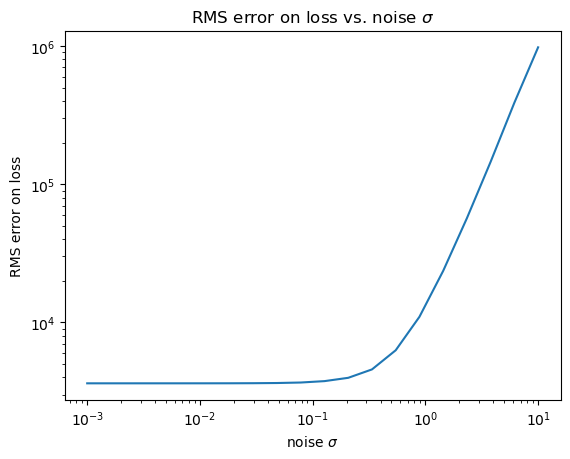

In [241]:
plt.plot(sigma_array, rms_errors)
plt.xlabel(r'noise $\sigma$')
plt.ylabel('RMS error on loss')
plt.xscale('log')
plt.yscale('log')
plt.title(r'RMS error on loss vs. noise $\sigma$')
plt.show()

100%|██████████| 150/150 [01:38<00:00,  1.53it/s]

The original parameters are m = 2.0, k = 4.0


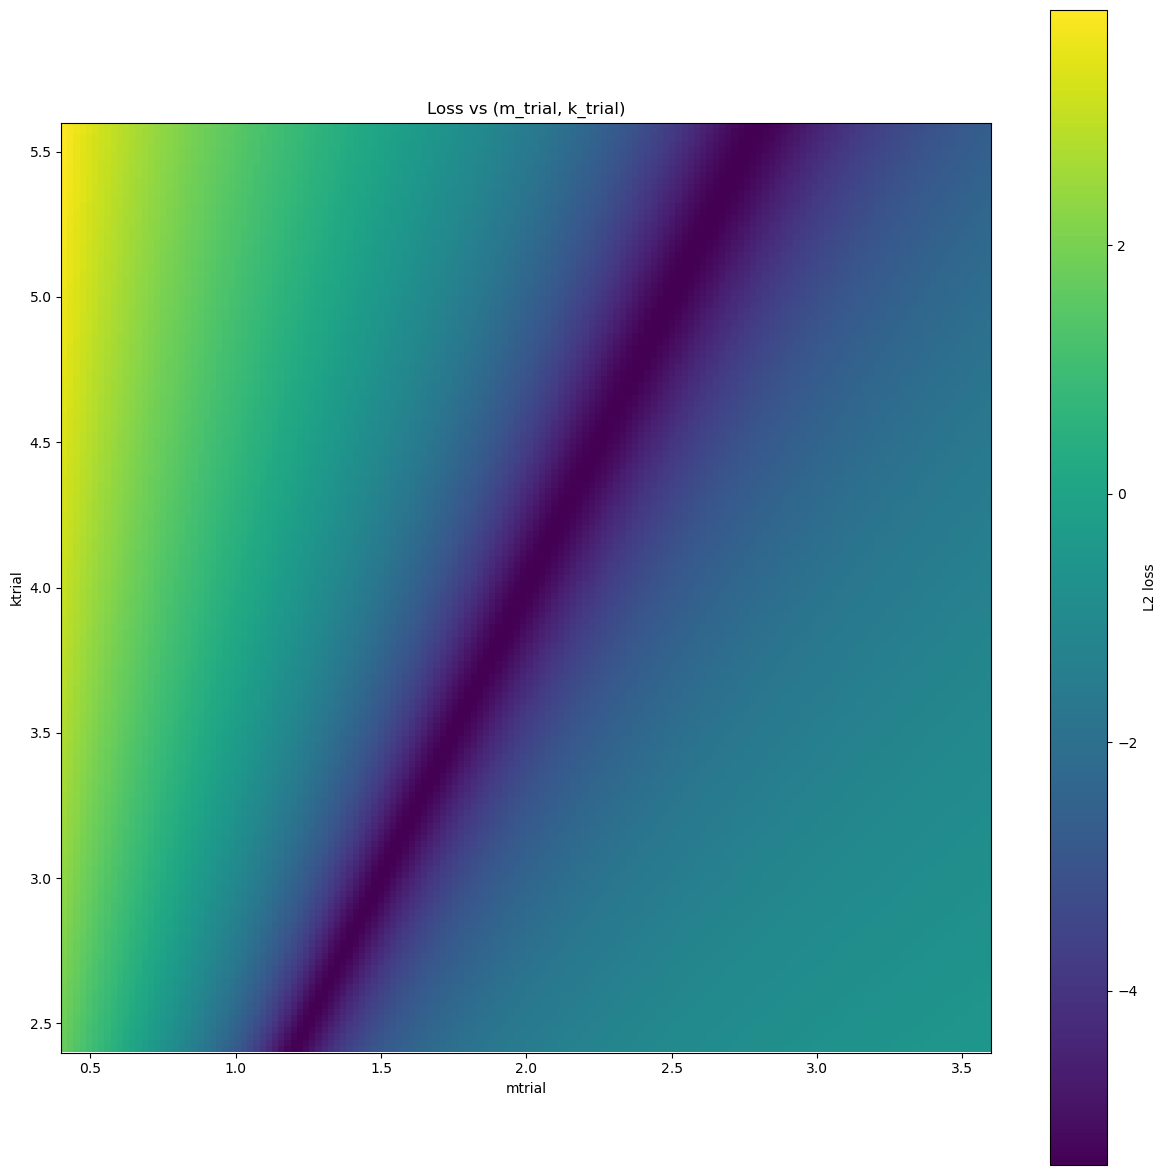

In [511]:
n_param_points = 150
box_width = 1.6

m_min = m[0] - box_width
m_max = m[0] + box_width
k_min = k[0] - box_width
k_max = k[0] + box_width
"""
m_min = 0.6
m_max = 1.4
k_min = 1.6
k_max = 2.4
"""
mtrialgrid = torch.linspace(m_min,m_max,n_param_points)
ktrialgrid = torch.linspace(k_min,k_max,n_param_points)


def L(q,qdot,m,k,alpha):
    return 0.5*m*qdot**2 - 0.5*k*q**2 - alpha*q**2*qdot**2

def loss(q,qdot,m,k,alpha,dataset):
    return torch.sum((QDDv(q,qdot,m,k,alpha) - dataset)**2)/dataset.size()[0]

qgrid = torch.linspace(q_min,q_max,n_points) #(n_points)
qdotgrid = torch.linspace(qdot_min,qdot_max,n_points) #(n_points)

#define flattened q, qdot arrays (n_points^2), (n_points^2), using new torch.expand.reshape method.
Q = qgrid.expand([n_points,n_points]).reshape(n_points**2)
QD = qdotgrid.expand([n_points,n_points]).reshape(n_points**2)

loss_mat = torch.zeros([n_param_points, n_param_points])


sz = out.size(1)
out_noisy = torch.clone(out) + 0.25*torch.randn(sz)

qdd_trials = torch.zeros(sz)

for i in tqdm.trange(n_param_points): #iterate over m
    mtrial = tensor([mtrialgrid[i]], requires_grad = True) #pick m_trial value from grid
    for j in range(n_param_points): #iterate over k
        ktrial = tensor([ktrialgrid[j]], requires_grad = True) #pick k_trial value from grid

        #qdd_trials = QDDv(Q,QD,mtrial,ktrial,alpha)
        
        #loss_mat[i,j] = torch.sum( (qdd_trials - out)**2 )/sz #calculate loss function
        loss_mat[i,j] = loss(Q,QD,mtrial,ktrial,alpha,out_noisy)




print(f"The original parameters are m = {m[0]}, k = {k[0]}")

#plotting
fig, axs = plt.subplots(1,1,figsize=(15,15))
test = axs.imshow(np.log(loss_mat.detach().numpy().T+1e-12), extent=[m_min,m_max,k_min,k_max],origin='lower')

axs.set_xlabel('mtrial')
axs.set_ylabel('ktrial')
fig.colorbar(test, ax=axs,label='L2 loss')
axs.set_title("Loss vs (m_trial, k_trial)")

plt.show()

